## Exploring Data

In this lab, you will learn how to explore data from ground-up. Of course, exploratory analysis also requires appropriate data cleaning and pre-processing (transformation, etc.) to be performed either priorly or concurrently. You will also learn how to read and interpret the data in JSON files.

* [I. Creating a cleaning pipeline](#sectionI)
* [II. Applying transformations before exploring](#sectionII)
* [III. Exploring JSON data](#sectionIII)

> **Credit note:** A portion of this lab was adapted from [UC Berkeley's Principles and Techniques of Data Science (DS 100)](https://www.textbook.ds100.org/).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

<a id="sectionI"></a>
## I. Creating a cleaning pipeline

We will be using the Berkeley Police Department's publicly available dataset to show how to create a cleaning pipeline. 

**What do the data contain?** Have a look at the [website](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5) where the dataset was obtained. It says "Calls for service (not criminal reports) within last 180 days." So, it contains very recent data (last 180 days), of calls to the police department for non-criminal problems.

**What is the structure of the data?** The data file is a CSV file. Get it uploaded to Colab (or you can choose to mount your Drive). It should be a comma-separated file, although sometimes it is difficult to know if the file has been formatted properly. `read_csv()` can be used to read the file and if it returned errors, then we have to dig deeper and manually resolve the formatting issues.

In [3]:
calls = pd.read_csv('Berkeley_PD_-_Calls_for_Service.csv')

In [4]:
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,19050601,ASSAULT/BATTERY MISD.,09/06/2019 12:00:00 AM,15:15,ASSAULT,5,12/21/2019 07:00:12 AM,"HILLEGASS AVENUE &DERBY ST\nBerkeley, CA",HILLEGASS AVENUE &DERBY ST,Berkeley,CA
1,19068295,FRAUD/FORGERY,11/26/2019 12:00:00 AM,12:00,FRAUD,2,12/21/2019 07:00:10 AM,"SHATTUCK AV & TELEGRAPH AV\nBerkeley, CA",SHATTUCK AV & TELEGRAPH AV,Berkeley,CA
2,19092646,IDENTITY THEFT,10/14/2019 12:00:00 AM,12:25,FRAUD,1,12/21/2019 07:00:10 AM,"RUSSELL STREET ST\nBerkeley, CA",RUSSELL STREET ST,Berkeley,CA
3,19042662,VEHICLE STOLEN,08/03/2019 12:00:00 AM,19:00,MOTOR VEHICLE THEFT,6,12/21/2019 07:00:11 AM,"0 B DOCK\nBerkeley, CA",0 B DOCK,Berkeley,CA
4,19049612,THEFT FROM AUTO,09/04/2019 12:00:00 AM,08:00,LARCENY - FROM VEHICLE,3,12/21/2019 07:00:12 AM,"700 FLORIDA AVE\nBerkeley, CA",700 FLORIDA AVE,Berkeley,CA


Based on the output above, the resulting dataframe looks OK and well-formed since we have properly named columns and the data seems to be intact.

**What are the attributes of this data?** Let's examine what the [website](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5) says about it.

| **Column** | **Description** | **Type**   |
|------:|-----------:|--------|
| CASENO | Case Number | Number |
| OFFENSE | Offense Type | Plain Text |
| EVENTDT | Date Event Occurred | Date & Time |
| EVENTTM | Time Event Occurred | Plain Text |
| CVLEGEND | Description of Event | Plain Text |
| CVDOW | Day of Week Event Occurred | Number |
| InDbDate | Date dataset was updated in the portal | Date & Time |
| Block_Location | Block level address of event | Location |
| BLKADDR | | Plain Text |
| City | | Plain Text |
| State | | Plain Text |

In [5]:
calls.dtypes

CASENO             int64
OFFENSE           object
EVENTDT           object
EVENTTM           object
CVLEGEND          object
CVDOW              int64
InDbDate          object
Block_Location    object
BLKADDR           object
City              object
State             object
dtype: object

### Check on missing data

The first thing to do is to check for missing data. However, before starting data analysis, we must check the following questions:

**Are there any missing values?** Do a simple check with pandas.

In [6]:
# this does not work. Append .any(axis=1) to make it work
null_rows = calls.isnull()  
calls[null_rows]        # boolean indexing

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`isnull()` applied on the whole dataframe does not produce the intended behaviour. This function needs to be applied to check for *any* NaN values along the column side (*axis=1*).

In [7]:
calls[null_rows].shape

(5417, 11)

There are 38 entries with at least a column with NaN value. All of them have missing BLKADDR (address) values. We also observe that all of them have Berkeley, CA recorded if the actual address location is missing. So perhaps, this is not a big problem.

**Any data that can be cleaned or transformed?**

In addition, an inspection of the EVENTDT column shows that it has the correct dates but records 12am for all of its times. Instead, the times are in the EVENTTM column in 24 hours format.

In [8]:
calls.head(7)

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,19050601,ASSAULT/BATTERY MISD.,09/06/2019 12:00:00 AM,15:15,ASSAULT,5,12/21/2019 07:00:12 AM,"HILLEGASS AVENUE &DERBY ST\nBerkeley, CA",HILLEGASS AVENUE &DERBY ST,Berkeley,CA
1,19068295,FRAUD/FORGERY,11/26/2019 12:00:00 AM,12:00,FRAUD,2,12/21/2019 07:00:10 AM,"SHATTUCK AV & TELEGRAPH AV\nBerkeley, CA",SHATTUCK AV & TELEGRAPH AV,Berkeley,CA
2,19092646,IDENTITY THEFT,10/14/2019 12:00:00 AM,12:25,FRAUD,1,12/21/2019 07:00:10 AM,"RUSSELL STREET ST\nBerkeley, CA",RUSSELL STREET ST,Berkeley,CA
3,19042662,VEHICLE STOLEN,08/03/2019 12:00:00 AM,19:00,MOTOR VEHICLE THEFT,6,12/21/2019 07:00:11 AM,"0 B DOCK\nBerkeley, CA",0 B DOCK,Berkeley,CA
4,19049612,THEFT FROM AUTO,09/04/2019 12:00:00 AM,08:00,LARCENY - FROM VEHICLE,3,12/21/2019 07:00:12 AM,"700 FLORIDA AVE\nBerkeley, CA",700 FLORIDA AVE,Berkeley,CA
5,19052852,MISSING ADULT,09/19/2019 12:00:00 AM,11:27,MISSING PERSON,4,12/21/2019 07:00:12 AM,"0 <UNKNOWN>\nBerkeley, CA",0 <UNKNOWN>,Berkeley,CA
6,19068080,THEFT MISD. (UNDER $950),12/01/2019 12:00:00 AM,12:00,LARCENY,0,12/21/2019 07:00:10 AM,"600 SHATTUCK SQ\nBerkeley, CA",600 SHATTUCK SQ,Berkeley,CA


As a data cleaning step, we want to merge the EVENTDT and EVENTTM columns to record both date and time in a single field. This single field can take the form of a [`DateTime`](https://docs.python.org/3/library/datetime.html) type, which can be created with pandas [`.to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) function. 

10-01-2022
01-10-2022

Jan 01, 2022

In [ ]:
'09/06/2019 12:00:00 AM' [:10] # 10 characters of the date

In [10]:
calls['EVENTDT'].str[:10] + ' ' + calls['EVENTTM'] # take the first 10

0       09/06/2019 15:15
1       11/26/2019 12:00
2       10/14/2019 12:25
3       08/03/2019 19:00
4       09/04/2019 08:00
              ...       
5412    09/29/2019 16:50
5413    09/29/2019 13:06
5414    12/13/2019 14:00
5415    11/07/2019 11:45
5416    07/12/2019 16:00
Length: 5417, dtype: object

In [11]:
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,19050601,ASSAULT/BATTERY MISD.,09/06/2019 12:00:00 AM,15:15,ASSAULT,5,12/21/2019 07:00:12 AM,"HILLEGASS AVENUE &DERBY ST\nBerkeley, CA",HILLEGASS AVENUE &DERBY ST,Berkeley,CA
1,19068295,FRAUD/FORGERY,11/26/2019 12:00:00 AM,12:00,FRAUD,2,12/21/2019 07:00:10 AM,"SHATTUCK AV & TELEGRAPH AV\nBerkeley, CA",SHATTUCK AV & TELEGRAPH AV,Berkeley,CA
2,19092646,IDENTITY THEFT,10/14/2019 12:00:00 AM,12:25,FRAUD,1,12/21/2019 07:00:10 AM,"RUSSELL STREET ST\nBerkeley, CA",RUSSELL STREET ST,Berkeley,CA
3,19042662,VEHICLE STOLEN,08/03/2019 12:00:00 AM,19:00,MOTOR VEHICLE THEFT,6,12/21/2019 07:00:11 AM,"0 B DOCK\nBerkeley, CA",0 B DOCK,Berkeley,CA
4,19049612,THEFT FROM AUTO,09/04/2019 12:00:00 AM,08:00,LARCENY - FROM VEHICLE,3,12/21/2019 07:00:12 AM,"700 FLORIDA AVE\nBerkeley, CA",700 FLORIDA AVE,Berkeley,CA


In [12]:
# solution 1
combined = calls['EVENTDT'].str[:10] + ' ' + calls['EVENTTM']
combined = pd.to_datetime(combined) # convert to datetime
combined.head()
#print(combined.dtype)
#combined.head()

0   2019-09-06 15:15:00
1   2019-11-26 12:00:00
2   2019-10-14 12:25:00
3   2019-08-03 19:00:00
4   2019-09-04 08:00:00
dtype: datetime64[ns]

In [ ]:
# solution 2
combined = pd.to_datetime(
    # Combine date and time strings
    calls['EVENTDT'].str[:10] + ' ' + calls['EVENTTM'],
    infer_datetime_format=True, # change the object to datetime format
)
combined.head()

Let's create a function to place the code that will do this merging of information. This allows the transformation (the function) to be applied to the entire dataframe. 

In [13]:
def combine_event_datetimes(calls):
    combined = pd.to_datetime(
        # Combine date and time strings
        calls['EVENTDT'].str[:10] + ' ' + calls['EVENTTM'],
        infer_datetime_format=True,
    )
    # new name = merge two columns: event date + event time
    return calls.assign(EVENTDTTM=combined) 

Pandas `assign` function creates new columns to a dataframe. So here, we specify that a new column `EVENTDTTM` is created in `calls` dataframe using the `combined` data. 

In [14]:
# this does not make it permanent.
# To do so, assign it to another new dataframe
calls.pipe(combine_event_datetimes).head()   

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,EVENTDTTM
0,19050601,ASSAULT/BATTERY MISD.,09/06/2019 12:00:00 AM,15:15,ASSAULT,5,12/21/2019 07:00:12 AM,"HILLEGASS AVENUE &DERBY ST\nBerkeley, CA",HILLEGASS AVENUE &DERBY ST,Berkeley,CA,2019-09-06 15:15:00
1,19068295,FRAUD/FORGERY,11/26/2019 12:00:00 AM,12:00,FRAUD,2,12/21/2019 07:00:10 AM,"SHATTUCK AV & TELEGRAPH AV\nBerkeley, CA",SHATTUCK AV & TELEGRAPH AV,Berkeley,CA,2019-11-26 12:00:00
2,19092646,IDENTITY THEFT,10/14/2019 12:00:00 AM,12:25,FRAUD,1,12/21/2019 07:00:10 AM,"RUSSELL STREET ST\nBerkeley, CA",RUSSELL STREET ST,Berkeley,CA,2019-10-14 12:25:00
3,19042662,VEHICLE STOLEN,08/03/2019 12:00:00 AM,19:00,MOTOR VEHICLE THEFT,6,12/21/2019 07:00:11 AM,"0 B DOCK\nBerkeley, CA",0 B DOCK,Berkeley,CA,2019-08-03 19:00:00
4,19049612,THEFT FROM AUTO,09/04/2019 12:00:00 AM,08:00,LARCENY - FROM VEHICLE,3,12/21/2019 07:00:12 AM,"700 FLORIDA AVE\nBerkeley, CA",700 FLORIDA AVE,Berkeley,CA,2019-09-04 08:00:00


The [`pipe`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html) function allows a function to be applied to the entire dataframe. Another similar kind of function, [`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html#pandas.DataFrame.apply) allows a function to be applied to a specific axis of the dataframe, row-wise or column-wise. 

**Is the data entered by a human?**

It looks like most of the data columns are machine-recorded, including the date, time, day of week, and location of the event.

In addition, the OFFENSE and CVLEGEND columns appear to contain consistent values. We can check the unique values in each column to see if anything was misspelled:

In [15]:
# list the content of it
print(calls['OFFENSE'].unique())
print(calls['OFFENSE'].nunique())

['ASSAULT/BATTERY MISD.' 'FRAUD/FORGERY' 'IDENTITY THEFT' 'VEHICLE STOLEN'
 'THEFT FROM AUTO' 'MISSING ADULT' 'THEFT MISD. (UNDER $950)' 'VANDALISM'
 'ROBBERY' 'BURGLARY AUTO' 'NARCOTICS' 'ALCOHOL OFFENSE'
 'BURGLARY RESIDENTIAL' 'BURGLARY COMMERCIAL' 'THEFT FELONY (OVER $950)'
 'DISTURBANCE' 'VEHICLE RECOVERED' 'SEXUAL ASSAULT FEL.'
 'ASSAULT/BATTERY FEL.' 'DOMESTIC VIOLENCE' 'GUN/WEAPON' 'ARSON'
 'DISTURBANCE - NOISE' 'VICE' 'BRANDISHING' 'THEFT FROM PERSON'
 'SEXUAL ASSAULT MISD.' '2ND RESPONSE' 'KIDNAPPING' 'MISSING JUVENILE'
 'VEHICLE CODE - DUI' 'MUNICIPAL CODE']
32


In [16]:
calls['CVLEGEND'].unique()

array(['ASSAULT', 'FRAUD', 'MOTOR VEHICLE THEFT',
       'LARCENY - FROM VEHICLE', 'MISSING PERSON', 'LARCENY', 'VANDALISM',
       'ROBBERY', 'BURGLARY - VEHICLE', 'DRUG VIOLATION',
       'LIQUOR LAW VIOLATION', 'BURGLARY - RESIDENTIAL',
       'BURGLARY - COMMERCIAL', 'DISORDERLY CONDUCT', 'RECOVERED VEHICLE',
       'SEX CRIME', 'FAMILY OFFENSE', 'WEAPONS OFFENSE', 'ARSON',
       'NOISE VIOLATION', 'KIDNAPPING', 'DUI', 'ALL OTHER OFFENSES'],
      dtype=object)

By checking the BLKADDR column, we find some inconsistencies -- that sometimes an address is recorded (e.g. 2500 LE CONTE AVE) but other times a cross street is recorded (e.g. ALLSTON WAY & FIFTH ST) which is not specific enough. This suggests that a human entered this data in and this column will be difficult to use for analysis. Fortunately, we can use the latitude and longitude of the event instead of the street address.

In [17]:
calls['BLKADDR'][[1, 5001]]

1       SHATTUCK AV & TELEGRAPH AV
5001                1500 EUCLID AV
Name: BLKADDR, dtype: object

Doing some random checks on the lattitude and longitude of the event shows that it is not entirely consistent as well. Some records contain the latitude and longitude information, some do not. 

In [18]:
# loc : indexing
calls.loc[100:109, 'Block_Location'].values   # look at 10 records from 100 to 109. Free to change this range

array(['MILVIA STREET & BANCROFT WY\nBerkeley, CA\n(37.867291, -122.270245)',
       '2800 TELEGRAPH AV\nBerkeley, CA\n(37.859309, -122.259291)',
       '2100 SHATTUCK AV\nBerkeley, CA\n(37.871167, -122.268285)',
       '1900 SHATTUCK AV\nBerkeley, CA\n(37.873687, -122.268616)',
       'TREMONT STREET & ESSEX ST\nBerkeley, CA\n(37.853552, -122.268286)',
       'SHATTUCK AVE\nBerkeley, CA',
       '1400 SHATTUCK AV\nBerkeley, CA\n(37.881957, -122.269551)',
       '1000 GILMAN ST\nBerkeley, CA\n(37.88014, -122.297498)',
       '1800 ACTON ST\nBerkeley, CA\n(37.872563, -122.284648)',
       'MARTIN LUTHER KING JR WY & CHANNING WY\nBerkeley, CA\n(37.865169, -122.272303)'],
      dtype=object)

In [ ]:
# regular expression
calls[calls.Block_Location.str.contains('(.*)*[\n]([(].*)')]

The `Block_Location` column seemed to contain strings that record address, latitutde and longitude. Regardless of whether it has the complete set of information or not, we can separate the latitutde and longitude, and discard the actual address which is not that valuable.

Using a sample record, the following procedure performs this transformation:

In [19]:
z = calls['Block_Location']
z = z.str.split('\n') # convert data to string, then split by the \n
#z.head() 
z.tail()                 # view last 5 for easy peek at the records that need processing

5412    [1300 SAN PABLO AV, Berkeley, CA, (37.880228, ...
5413    [1200 RUSSELL ST, Berkeley, CA, (37.853864, -1...
5414    [1900 GRANT ST, Berkeley, CA, (37.873017, -122...
5415    [1500 HEARST AV, Berkeley, CA, (37.872158, -12...
5416    [2400 BONAR ST, Berkeley, CA, (37.863241, -122...
Name: Block_Location, dtype: object

> **Note**: This [str.split](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html) is one that belongs to pandas, not the [split](https://docs.python.org/3.8/library/stdtypes.html#str.split) function of the Python string class.

In [20]:
z = z.str[2]    # discard the first 3 items in the list, leaving the (lat,long) 
z.tail()

5412    (37.880228, -122.295798)
5413    (37.853864, -122.285643)
5414    (37.873017, -122.275481)
5415    (37.872158, -122.282066)
5416    (37.863241, -122.286176)
Name: Block_Location, dtype: object

In [21]:
# it is a string, not a tuple, so we need to remove the parentheses, split again by , and dump both into separate columns
z = z.str[1:-1].str.split(', ', expand=True)  
z.tail()

,0,1
5412,37.880228,-122.295798
5413,37.853864,-122.285643
5414,37.873017,-122.275481
5415,37.872158,-122.282066
5416,37.863241,-122.286176


In [20]:
# finally, to rename the column names...
z = z.rename(columns={0: "Latitude", 1: "Longitude"})
#z.tail()
z.head(40)

,Latitude,Longitude
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,37.873687,-122.268616


The remaining step will be to join this two columns back to the original dataframe `calls`. Let's put this all into a function:

In [22]:
def split_lat_lon(calls):
    result = calls.join(
        calls['Block_Location'].str.split('\n').str[2].str[1:-1].str.split(', ', expand=True).rename(columns={0: 'Latitude', 1: 'Longitude'})
        # Get coords from string
            #.str.split('\n').str[2]
        # Remove parens from coords
            #.str[1:-1]
        # Split latitude and longitude
            #.str.split(', ', expand=True)
            #.rename(columns={0: 'Latitude', 1: 'Longitude'})
    )
    return result

calls.pipe(split_lat_lon).tail()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Latitude,Longitude
5412,19055171,THEFT MISD. (UNDER $950),09/29/2019 12:00:00 AM,16:50,LARCENY,0,12/21/2019 07:00:13 AM,"1300 SAN PABLO AV\nBerkeley, CA\n(37.880228, -...",1300 SAN PABLO AV,Berkeley,CA,37.880228,-122.295798
5413,19055139,DISTURBANCE,09/29/2019 12:00:00 AM,13:06,DISORDERLY CONDUCT,0,12/21/2019 07:00:13 AM,"1200 RUSSELL ST\nBerkeley, CA\n(37.853864, -12...",1200 RUSSELL ST,Berkeley,CA,37.853864,-122.285643
5414,19092811,VANDALISM,12/13/2019 12:00:00 AM,14:00,VANDALISM,5,12/21/2019 07:00:11 AM,"1900 GRANT ST\nBerkeley, CA\n(37.873017, -122....",1900 GRANT ST,Berkeley,CA,37.873017,-122.275481
5415,19092456,THEFT FELONY (OVER $950),11/07/2019 12:00:00 AM,11:45,LARCENY,4,12/21/2019 07:00:09 AM,"1500 HEARST AV\nBerkeley, CA\n(37.872158, -122...",1500 HEARST AV,Berkeley,CA,37.872158,-122.282066
5416,19091384,VANDALISM,07/12/2019 12:00:00 AM,16:00,VANDALISM,5,12/21/2019 07:00:11 AM,"2400 BONAR ST\nBerkeley, CA\n(37.863241, -122....",2400 BONAR ST,Berkeley,CA,37.863241,-122.286176


Hooray! It works. But what happens to entries without the lat. and long. information?

In [23]:
calls.pipe(split_lat_lon).head(10)    

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Latitude,Longitude
0,19050601,ASSAULT/BATTERY MISD.,09/06/2019 12:00:00 AM,15:15,ASSAULT,5,12/21/2019 07:00:12 AM,"HILLEGASS AVENUE &DERBY ST\nBerkeley, CA",HILLEGASS AVENUE &DERBY ST,Berkeley,CA,NaN,NaN
1,19068295,FRAUD/FORGERY,11/26/2019 12:00:00 AM,12:00,FRAUD,2,12/21/2019 07:00:10 AM,"SHATTUCK AV & TELEGRAPH AV\nBerkeley, CA",SHATTUCK AV & TELEGRAPH AV,Berkeley,CA,NaN,NaN
2,19092646,IDENTITY THEFT,10/14/2019 12:00:00 AM,12:25,FRAUD,1,12/21/2019 07:00:10 AM,"RUSSELL STREET ST\nBerkeley, CA",RUSSELL STREET ST,Berkeley,CA,NaN,NaN
3,19042662,VEHICLE STOLEN,08/03/2019 12:00:00 AM,19:00,MOTOR VEHICLE THEFT,6,12/21/2019 07:00:11 AM,"0 B DOCK\nBerkeley, CA",0 B DOCK,Berkeley,CA,NaN,NaN
4,19049612,THEFT FROM AUTO,09/04/2019 12:00:00 AM,08:00,LARCENY - FROM VEHICLE,3,12/21/2019 07:00:12 AM,"700 FLORIDA AVE\nBerkeley, CA",700 FLORIDA AVE,Berkeley,CA,NaN,NaN
5,19052852,MISSING ADULT,09/19/2019 12:00:00 AM,11:27,MISSING PERSON,4,12/21/2019 07:00:12 AM,"0 <UNKNOWN>\nBerkeley, CA",0 <UNKNOWN>,Berkeley,CA,NaN,NaN
6,19068080,THEFT MISD. (UNDER $950),12/01/2019 12:00:00 AM,12:00,LARCENY,0,12/21/2019 07:00:10 AM,"600 SHATTUCK SQ\nBerkeley, CA",600 SHATTUCK SQ,Berkeley,CA,NaN,NaN
7,19041310,VANDALISM,07/29/2019 12:00:00 AM,00:30,VANDALISM,1,12/21/2019 07:00:11 AM,"6000 CHABOLYN TE\nBerkeley, CA",6000 CHABOLYN TE,Berkeley,CA,NaN,NaN
8,19059779,ASSAULT/BATTERY MISD.,10/21/2019 12:00:00 AM,13:47,ASSAULT,1,12/21/2019 07:00:09 AM,"HEARST AVE\nBerkeley, CA",HEARST AVE,Berkeley,CA,NaN,NaN
9,19057555,ROBBERY,10/10/2019 12:00:00 AM,19:08,ROBBERY,4,12/21/2019 07:00:08 AM,"1900 SHATTUCK AV\nBerkeley, CA\n(37.873687, -1...",1900 SHATTUCK AV,Berkeley,CA,37.873687,-122.268616


Yes, NaN as you would expect since the values are not available. Assessing the damage...

In [24]:
calls.pipe(split_lat_lon).isnull().any(axis=1).sum()  

238

That's quite a lot of rows...but to put things into perspective, how many percent of the entire dataframe has this issue?

In [25]:
calls.pipe(split_lat_lon).isnull().any(axis=1).sum() / len(calls) * 100

4.393575779952004

< 5% is quite reasonable in most cases, so we can leave it as such until further processing is needed.

<hr>

The `CVDOW` column contains a number which indicates the day of the week. E.g. 0 indicates Sunday, 1 indicates Monday, etc.
Let's first create a mapping between the number and the day.

In [26]:
day_of_week = pd.DataFrame({'CVDOW':[0, 1, 2, 3, 4, 5, 6], 'Day': ['Sunday', 'Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']})
day_of_week

,CVDOW,Day
0,0,Sunday
1,1,Monday
2,2,Tuesday
3,3,Wednesday
4,4,Thursday
5,5,Friday
6,6,Saturday


Write another function which finds the day of the week (based on CVDOW) and merge it back to the dataframe.

In [27]:
def match_weekday(calls):
    return calls.merge(day_of_week, on='CVDOW')  # the 'on' takes on a column which exists on both sides

calls.pipe(match_weekday).head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Day
0,19050601,ASSAULT/BATTERY MISD.,09/06/2019 12:00:00 AM,15:15,ASSAULT,5,12/21/2019 07:00:12 AM,"HILLEGASS AVENUE &DERBY ST\nBerkeley, CA",HILLEGASS AVENUE &DERBY ST,Berkeley,CA,Friday
1,19037903,ROBBERY,07/12/2019 12:00:00 AM,15:45,ROBBERY,5,12/21/2019 07:00:11 AM,"2400 DWIGHT WY\nBerkeley, CA\n(37.864826, -122...",2400 DWIGHT WY,Berkeley,CA,Friday
2,19060736,BURGLARY COMMERCIAL,10/25/2019 12:00:00 AM,19:25,BURGLARY - COMMERCIAL,5,12/21/2019 07:00:09 AM,"2600 TELEGRAPH AV\nBerkeley, CA\n(37.862927, -...",2600 TELEGRAPH AV,Berkeley,CA,Friday
3,19042425,THEFT MISD. (UNDER $950),08/02/2019 12:00:00 AM,20:47,LARCENY,5,12/21/2019 07:00:11 AM,"1400 SHATTUCK AV\nBerkeley, CA\n(37.881957, -1...",1400 SHATTUCK AV,Berkeley,CA,Friday
4,19046958,BURGLARY AUTO,08/23/2019 12:00:00 AM,12:40,BURGLARY - VEHICLE,5,12/21/2019 07:00:12 AM,"2000 5TH ST\nBerkeley, CA\n(37.867271, -122.29...",2000 5TH ST,Berkeley,CA,Friday


And finally, let's write a function to drop the columns that we no longer need:

In [28]:
def drop_unneeded_cols(calls):
    return calls.drop(columns=['CVDOW', 'InDbDate', 'Block_Location', 'City',
                               'State', 'EVENTDT', 'EVENTTM'])

The reason why we have been constructing functions for all these cleaning and transformation steps, is so that we can now make this into a cleaning pipeline, which we can "pipe" the dataframe through. Imagine the data being passed from one procedure to another, until the end. The eventual output will be one that is completely cleaned and transformed.

In [29]:
calls_final = (calls.pipe(combine_event_datetimes)
               .pipe(split_lat_lon)
               .pipe(match_weekday)
               .pipe(drop_unneeded_cols))

calls_final

,CASENO,OFFENSE,CVLEGEND,BLKADDR,EVENTDTTM,Latitude,Longitude,Day
0,19050601,ASSAULT/BATTERY MISD.,ASSAULT,HILLEGASS AVENUE &DERBY ST,2019-09-06 15:15:00,NaN,NaN,Friday
1,19037903,ROBBERY,ROBBERY,2400 DWIGHT WY,2019-07-12 15:45:00,37.864826,-122.260719,Friday
2,19060736,BURGLARY COMMERCIAL,BURGLARY - COMMERCIAL,2600 TELEGRAPH AV,2019-10-25 19:25:00,37.862927,-122.258784,Friday
3,19042425,THEFT MISD. (UNDER $950),LARCENY,1400 SHATTUCK AV,2019-08-02 20:47:00,37.881957,-122.269551,Friday
4,19046958,BURGLARY AUTO,BURGLARY - VEHICLE,2000 5TH ST,2019-08-23 12:40:00,37.867271,-122.298682,Friday
...,...,...,...,...,...,...,...,...
5412,19055360,BURGLARY AUTO,BURGLARY - VEHICLE,700 SAN LORENZO AVE,2019-09-29 20:00:00,NaN,NaN,Sunday
5413,19041273,BURGLARY AUTO,BURGLARY - VEHICLE,1900 STUART ST,2019-07-28 20:10:00,37.857951,-122.271494,Sunday
5414,19055075,ROBBERY,ROBBERY,1600 OXFORD ST,2019-09-29 02:15:00,37.878552,-122.266844,Sunday
5415,19055171,THEFT MISD. (UNDER $950),LARCENY,1300 SAN PABLO AV,2019-09-29 16:50:00,37.880228,-122.295798,Sunday


In [30]:
calls_final.to_csv('calls_CLEANED.csv', index=False)

DateTime types in Python allow easy access to attributes relating to date and time. For instance, to extract the month from the datetime value:

In [31]:
calls_final.head(3)

,CASENO,OFFENSE,CVLEGEND,BLKADDR,EVENTDTTM,Latitude,Longitude,Day
0,19050601,ASSAULT/BATTERY MISD.,ASSAULT,HILLEGASS AVENUE &DERBY ST,2019-09-06 15:15:00,NaN,NaN,Friday
1,19037903,ROBBERY,ROBBERY,2400 DWIGHT WY,2019-07-12 15:45:00,37.864826,-122.260719,Friday
2,19060736,BURGLARY COMMERCIAL,BURGLARY - COMMERCIAL,2600 TELEGRAPH AV,2019-10-25 19:25:00,37.862927,-122.258784,Friday


In [32]:
calls_final['EVENTDTTM'].dt.month
#calls_final['EVENTDTTM'].dt.name
#calls_final['EVENTDTTM'].dt.day
#calls_final['EVENTDTTM'].dt.dayname

0        9
1        7
2       10
3        8
4        8
        ..
5412     9
5413     7
5414     9
5415     9
5416     9
Name: EVENTDTTM, Length: 5417, dtype: int64

Other datetime properties such as `year`, `day`, `min`, `max` can also be used.

You can also sort the dataframe based on datetime, from oldest to newest.

In [33]:
calls_final.sort_values('EVENTDTTM')

,CASENO,OFFENSE,CVLEGEND,BLKADDR,EVENTDTTM,Latitude,Longitude,Day
4781,19035002,FRAUD/FORGERY,FRAUD,1200 SPRUCE ST,2019-06-23 00:00:00,37.886086,-122.266573,Sunday
4897,19043154,THEFT FELONY (OVER $950),LARCENY,2100 SHATTUCK AV,2019-06-23 00:00:00,37.871167,-122.268285,Sunday
5342,19034420,THEFT MISD. (UNDER $950),LARCENY,2800 CALIFORNIA ST,2019-06-23 00:00:00,37.857216,-122.277614,Sunday
5010,19092570,THEFT FELONY (OVER $950),LARCENY,2400 RIDGE RD,2019-06-23 01:00:00,37.875865,-122.261749,Sunday
5211,19034202,BURGLARY AUTO,BURGLARY - VEHICLE,2500 DURANT AV,2019-06-23 01:13:00,37.867852,-122.258699,Sunday
...,...,...,...,...,...,...,...,...
3203,19071637,DISTURBANCE,DISORDERLY CONDUCT,2200 SHATTUCK AV,2019-12-18 17:06:00,37.869363,-122.268028,Wednesday
3702,19092875,BURGLARY AUTO,BURGLARY - VEHICLE,1000 GILMAN ST,2019-12-18 18:30:00,37.88014,-122.297498,Wednesday
3244,19071652,BURGLARY AUTO,BURGLARY - VEHICLE,3000 TELEGRAPH AV,2019-12-18 19:05:00,37.855435,-122.259841,Wednesday
3528,19071651,BURGLARY AUTO,BURGLARY - VEHICLE,1800 UNIVERSITY AV,2019-12-18 19:10:00,37.871246,-122.274991,Wednesday


<a id="sectionII"></a>
## II. Using graphical presentations to explore

Here's an interesting dataset containing baby names (from US) from year 1880 to 1989. There's easily close to 2 million rows in this dataset! Depending on your computer, you may encounter some error opening this file in MS Excel not because of the size of the data (which is only about 32 MB) but the sheer number of rows it need to load. Loading it on pandas is really convenient and fast.

In [41]:
baby = pd.read_csv('babynames.csv')
baby

,Name,Sex,Count,Year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
...,...,...,...,...
1957041,Zylas,M,5,2018
1957042,Zyran,M,5,2018
1957043,Zyrie,M,5,2018
1957044,Zyron,M,5,2018


In [42]:
firstchar = lambda x: x[0] # first element
names = baby['Name']
names.apply(firstchar)

0          M
1          A
2          E
3          E
4          M
          ..
1957041    Z
1957042    Z
1957043    Z
1957044    Z
1957045    Z
Name: Name, Length: 1957046, dtype: object

In [43]:
firstchar = lambda x: x.lower()
names = baby['Name']
names.apply(firstchar)

0               mary
1               anna
2               emma
3          elizabeth
4             minnie
             ...    
1957041        zylas
1957042        zyran
1957043        zyrie
1957044        zyron
1957045        zzyzx
Name: Name, Length: 1957046, dtype: object

In [44]:
names = baby['Name']
names.apply(len).max()

15

Now, let's say we have an interesting thought about using the last letter of a name to predict the sex of the baby. Do you think this is possible? Or does it even make sense in the first place?

Since we will not be doing any kind of prediction right now, we could try and check if this makes sense: find the counts of each last letter and see how "correlated" it is with the baby's sex (male/female).

Pandas Series has an `apply()` method which takes in a function and applies it to each value in the Series. It's similar the `pipe` function we saw earlier (applied to entire dataframe), but this applies to a Series or a column of a DataFrame (also a Series). Passing in a simple built-in function like `len` immediately gets us the length of each record's Name. E.g. 'Mary' has 4 letters, 'Elizabeth' has 9.

In [45]:
names = baby['Name']
names.apply(len)

0          4
1          4
2          4
3          9
4          6
          ..
1957041    5
1957042    5
1957043    5
1957044    5
1957045    5
Name: Name, Length: 1957046, dtype: int64

To extract the last letter of each name, we can define our own function to pass into `apply()`:

In [46]:
def last_letter(string):
    return string[-1]

names.apply(last_letter)

0          y
1          a
2          a
3          h
4          e
          ..
1957041    s
1957042    n
1957043    e
1957044    n
1957045    x
Name: Name, Length: 1957046, dtype: object

In [47]:
names.apply(lambda x: x[0]) # 0 -> first element

0          M
1          A
2          E
3          E
4          M
          ..
1957041    Z
1957042    Z
1957043    Z
1957044    Z
1957045    Z
Name: Name, Length: 1957046, dtype: object

Although `apply()` is flexible, it is often faster to use the built-in string manipulation functions in pandas when dealing with text data. Pandas provides access to string manipulation functions using the .str attribute of Series.

In [48]:
names = baby['Name']
names.str.len()

0          4
1          4
2          4
3          9
4          6
          ..
1957041    5
1957042    5
1957043    5
1957044    5
1957045    5
Name: Name, Length: 1957046, dtype: int64

We can even directly slice out the last letter of each name in a similar way:

In [53]:
names.str[-1]

0          y
1          a
2          a
3          h
4          e
          ..
1957041    s
1957042    n
1957043    e
1957044    n
1957045    x
Name: Name, Length: 1957046, dtype: object

Let's add this last letters to a new column in our dataframe.

In [49]:
baby['Last'] = names.str[-1] #adding a new column (last name) to the dataframe
baby

,Name,Sex,Count,Year,Last
0,Mary,F,7065,1880,y
1,Anna,F,2604,1880,a
2,Emma,F,2003,1880,a
3,Elizabeth,F,1939,1880,h
4,Minnie,F,1746,1880,e
...,...,...,...,...,...
1957041,Zylas,M,5,2018,s
1957042,Zyran,M,5,2018,n
1957043,Zyrie,M,5,2018,e
1957044,Zyron,M,5,2018,n


Next, to compute the sex distribution for each last letter, we need to group by both Last and Sex.

In [50]:
baby.groupby(['Last', 'Sex']).sum()

Count       Year
Last Sex                     
a    F    59391880  941103979
     M     1993271   55386008
b    F       18544    1171599
     M     1483673    8060364
c    F       32585    1714707
     M     1712648   11502830
d    F      761320   13924449
     M    16497557   79205369
e    F    38039540  493693112
     M    14974942  194990241
f    F        2747     385303
     M      215470    7148666
g    F       38148    3814394
     M      610504   11385827
h    F     8406833  107706424
     M     7129349   43922497
i    F     4002255  113984159
     M     1000546   46277842
j    F        3817     492664
     M       36730    3347946
k    F       42140    3492993
     M     5477925   32530898
l    F     5919008   77513707
     M    15304475  132551981
m    F      443438    8997784
     M     5968735   30852609
n    F    20546619  240594888
     M    39296015  395299611
o    F      415970   18001693
     M     4494466  118444608
p    F        4703     769734
     M      689447    4318995
q    F         804     104549
     M       14264    1351219
r    F     4084123   32195648
     M    10629517   94018888
s    F     3751649   43269223
     M    17602667  115727560
t    F     2555442   24022110
     M     9612818   46269905
u    F       90103    4986119
     M       95292    6728169
v    F        5600     266507
     M       58854    4000350
w    F       67010    1548136
     M     3109944    4890096
x    F       43379    2435325
     M      686044    5314550
y    F    25267475  144809943
     M    18751677  117170375
z    F      144100    4459647
     M      126963   10111326

In [51]:
grp = baby.groupby(['Last', 'Sex'])
grp.sum()

Count       Year
Last Sex                     
a    F    59391880  941103979
     M     1993271   55386008
b    F       18544    1171599
     M     1483673    8060364
c    F       32585    1714707
     M     1712648   11502830
d    F      761320   13924449
     M    16497557   79205369
e    F    38039540  493693112
     M    14974942  194990241
f    F        2747     385303
     M      215470    7148666
g    F       38148    3814394
     M      610504   11385827
h    F     8406833  107706424
     M     7129349   43922497
i    F     4002255  113984159
     M     1000546   46277842
j    F        3817     492664
     M       36730    3347946
k    F       42140    3492993
     M     5477925   32530898
l    F     5919008   77513707
     M    15304475  132551981
m    F      443438    8997784
     M     5968735   30852609
n    F    20546619  240594888
     M    39296015  395299611
o    F      415970   18001693
     M     4494466  118444608
p    F        4703     769734
     M      689447    4318995
q    F         804     104549
     M       14264    1351219
r    F     4084123   32195648
     M    10629517   94018888
s    F     3751649   43269223
     M    17602667  115727560
t    F     2555442   24022110
     M     9612818   46269905
u    F       90103    4986119
     M       95292    6728169
v    F        5600     266507
     M       58854    4000350
w    F       67010    1548136
     M     3109944    4890096
x    F       43379    2435325
     M      686044    5314550
y    F    25267475  144809943
     M    18751677  117170375
z    F      144100    4459647
     M      126963   10111326

Notice that Year is also summed up since every non-grouped column is passed into the aggregation function. To avoid this, we can select out the desired columns before calling .groupby().

In [52]:
# When lines get long, you can wrap the entire expression in parentheses
# and insert newlines before each method call. This way of writing codes makes it easier to read, but does the same thing
letter_dist = (
    baby[['Last', 'Sex', 'Count']] #broken the dataframe, but doesnt affect the main
    .groupby(['Last', 'Sex'])
    .sum()
)
letter_dist #multiple pipelines of the function

Count
Last Sex          
a    F    59391880
     M     1993271
b    F       18544
     M     1483673
c    F       32585
     M     1712648
d    F      761320
     M    16497557
e    F    38039540
     M    14974942
f    F        2747
     M      215470
g    F       38148
     M      610504
h    F     8406833
     M     7129349
i    F     4002255
     M     1000546
j    F        3817
     M       36730
k    F       42140
     M     5477925
l    F     5919008
     M    15304475
m    F      443438
     M     5968735
n    F    20546619
     M    39296015
o    F      415970
     M     4494466
p    F        4703
     M      689447
q    F         804
     M       14264
r    F     4084123
     M    10629517
s    F     3751649
     M    17602667
t    F     2555442
     M     9612818
u    F       90103
     M       95292
v    F        5600
     M       58854
w    F       67010
     M     3109944
x    F       43379
     M      686044
y    F    25267475
     M    18751677
z    F      144100
     M      126963

In [53]:
letter_dist = (
    baby[['Last', 'Sex', 'Count']] #broken the dataframe, but doesnt affect the main
    .groupby(['Last', 'Sex'])
    .sum()
)
letter_dist.unstack() #multiple pipelines of the function

Count          
Sex          F         M
Last                    
a     59391880   1993271
b        18544   1483673
c        32585   1712648
d       761320  16497557
e     38039540  14974942
f         2747    215470
g        38148    610504
h      8406833   7129349
i      4002255   1000546
j         3817     36730
k        42140   5477925
l      5919008  15304475
m       443438   5968735
n     20546619  39296015
o       415970   4494466
p         4703    689447
q          804     14264
r      4084123  10629517
s      3751649  17602667
t      2555442   9612818
u        90103     95292
v         5600     58854
w        67010   3109944
x        43379    686044
y     25267475  18751677
z       144100    126963

Besides having string extensions, pandas also provides built-in plotting functionality for most basic plots, including bar charts, histograms, line charts, and scatterplots. To make a plot from a DataFrame, use the [`plot`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.plot.html) function. 

<AxesSubplot:ylabel='Last,Sex'>

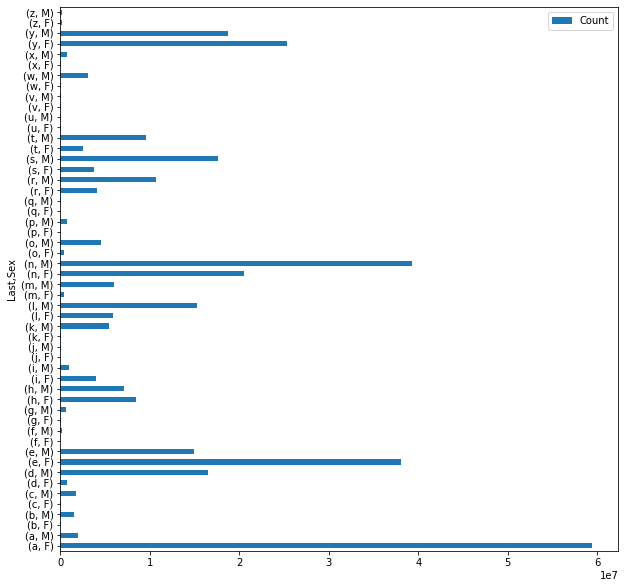

In [54]:
# We use the figsize option to make the plot larger
letter_dist.plot(kind='barh', figsize=(10, 10))
# or do it this way:
# letter_dist.plot.barh(figsize=(10, 10))

So without needing to format the dataframe properly for plotting, what we ended up with is pandas automatically create pairs of Last and Sex values and plot the bars based on the count values.

Although this plot shows the distribution of letters and sexes, the male and female bars are difficult to tell apart. By looking at the pandas docs on plotting, we learn that pandas plots one group of bars for row column in the DataFrame, showing one differently colored bar for each column. In other words, if we can *pivot* the Sex values (only 2 values) into column form, thus creating 2 columns, then we can plot a group of 2 bars for each Last value. This means that a pivoted version of the letter_dist table will have the right format.

In [55]:
baby.dtypes

Name     object
Sex      object
Count     int64
Year      int64
Last     object
dtype: object

In [56]:
letter_pivot = pd.pivot_table( #pivot table = to summarize dataset
    baby, index='Last', columns='Sex', values='Count', aggfunc='sum'
    #baby itself is a dataframe
    )
letter_pivot.head(10)

Sex,F,M
Last,,
a,59391880,1993271
b,18544,1483673
c,32585,1712648
d,761320,16497557
e,38039540,14974942
f,2747,215470
g,38148,610504
h,8406833,7129349
i,4002255,1000546


<AxesSubplot:ylabel='Last'>

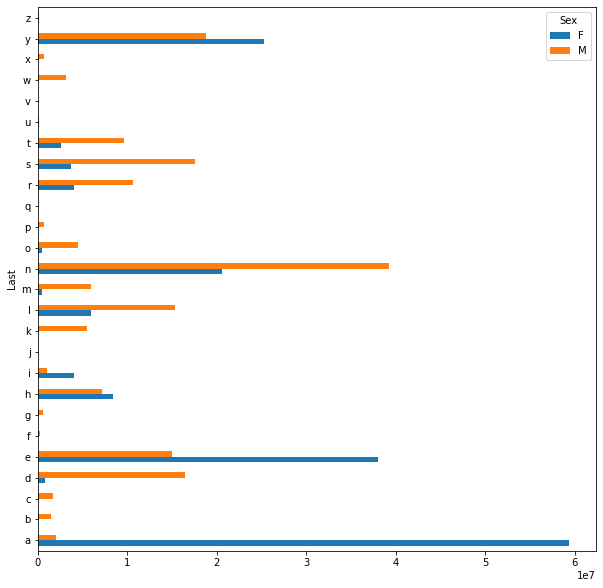

In [62]:
letter_pivot.plot.barh(figsize=(10, 10)) #barh = bar histogram

Notice that pandas conveniently generates a legend for us as well. (In `matplotlib` directly,  we normally have to specify if you want a legend displayed.) 

In terms of the chart, it may still be difficult to interpret. We plot the counts for each letter and sex which causes some bars to appear very long and others to be almost invisible. We should instead plot the proportion of male and female babies for each last letter. "Proportion" give us a sense of relative comparison between two values of a similar attribute, rather than relying on the hard value, which may be sitting on a large range.

In [57]:
sum_for_each_letter = letter_pivot['F'] + letter_pivot['M']

letter_pivot['F prop'] = letter_pivot['F'] / sum_for_each_letter
letter_pivot['M prop'] = letter_pivot['M'] / sum_for_each_letter
letter_pivot

Sex,F,M,F prop,M prop
Last,,,,
a,59391880,1993271,0.967528,0.032472
b,18544,1483673,0.012344,0.987656
c,32585,1712648,0.018671,0.981329
d,761320,16497557,0.044112,0.955888
e,38039540,14974942,0.717531,0.282469
f,2747,215470,0.012588,0.987412
g,38148,610504,0.058811,0.941189
h,8406833,7129349,0.541113,0.458887
i,4002255,1000546,0.800003,0.199997


Keep it mind too that we possibly want to sort the proportional values (either M or F, your choice), so that we can have them ranked in the chart. So, we can construct the plot this way:

<AxesSubplot:ylabel='Last'>

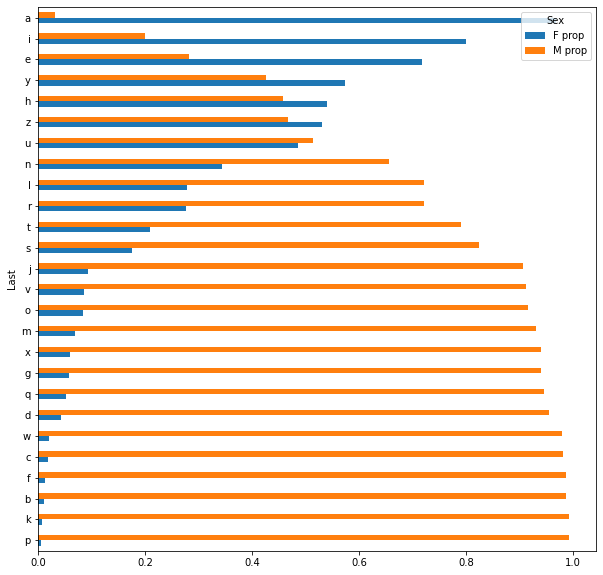

In [58]:
letter_pivot[['F prop', 'M prop']].sort_values('F prop').plot.barh(figsize=(10, 10))

<AxesSubplot:ylabel='Last'>

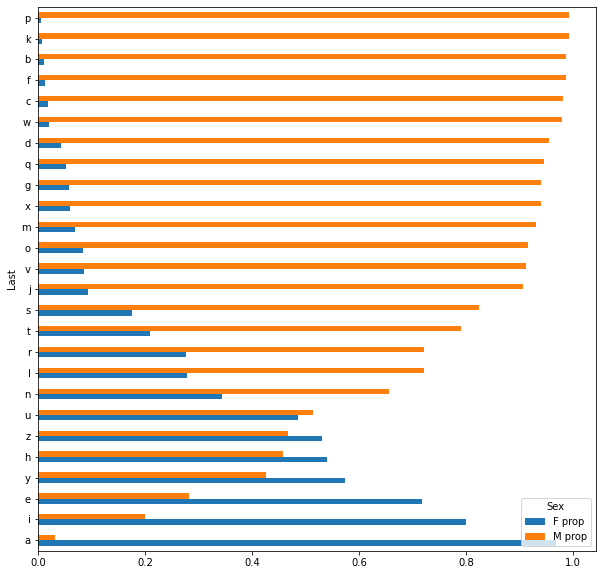

In [65]:
letter_pivot[['F prop', 'M prop']].sort_values('M prop').plot.barh(figsize=(10, 10))
#prop = proportional

**Observations**; We can see that almost all first names that end in 'p' are male and names that end in 'a' are female! In general, the difference between bar lengths for many letters implies that we can often make a good guess to a person's sex if we just know the last letter of their first name. On a contrary, first names that end with 'u' and 'h' are probably harder to guess the person's sex.

Re-experiment again by considering the last two letters of each baby's name, instead of the last letter. E.g. 'Sarah' is 'ah', and 'Mary' is 'ry'. This means that we are now considering a "syllable", or some unit of pronounciation, and to explore if we are able to see obvious differences between syllables that are found in Male names and Female names.

In [88]:
baby['Last_Two'] = names.str[-2:]
baby

,Name,Sex,Count,Year,Last,Last_Two
0,Mary,F,7065,1880,y,ry
1,Anna,F,2604,1880,a,na
2,Emma,F,2003,1880,a,ma
3,Elizabeth,F,1939,1880,h,th
4,Minnie,F,1746,1880,e,ie
...,...,...,...,...,...,...
1957041,Zylas,M,5,2018,s,as
1957042,Zyran,M,5,2018,n,an
1957043,Zyrie,M,5,2018,e,ie
1957044,Zyron,M,5,2018,n,on


<a id="sectionIII"></a>
## III. Exploring JSON data

So far we have been reading from relatively convenient structured formats like CSV. If we encounter semi-structured kind of data like JSON or XML, how can we read them? Fortunately, Python comes with a JSON library package that can help us load JSON files.

In this section, we will be using [Stops data](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Stop-Data/6e9j-pj9p) from Berkeley Police Department which is also made publicly available since 2015. This data records all vehicle detentions (including bicycles) and pedestrian detentions (up to 5 persons) made by the police in a number of categories. The incident number, date and time, location and disposition codes are also provided. 

In [59]:
import json

In [60]:
# Note that this could cause our computer to run out of memory if the file
# is large. In this case, we've verified that the file is small enough to
# read in beforehand.
with open('stops.json') as f:
    stops_dict = json.load(f)

stops_dict.keys()

dict_keys(['meta', 'data'])

Dictionaries. Access the keys to see the values.

In [61]:
stops_dict['meta']

{'view': {'id': '6e9j-pj9p',
  'name': 'Berkeley PD - Stop Data',
  'attribution': 'Berkeley Police Department',
  'averageRating': 0,
  'category': 'Public Safety',
  'createdAt': 1444171604,
  'description': 'This data was extracted from the Departmentâ€™s Public Safety Server and covers the data beginning January 26, 2015.  On January 26, 2015 the department began collecting data pursuant to General Order B-4 (issued December 31, 2014).  Under that order, officers were required to provide certain data after making all vehicle detentions (including bicycles) and pedestrian detentions (up to five persons).  This data set lists stops by police in the categories of traffic, suspicious vehicle, pedestrian and bicycle stops.  Incident number, date and time, location and disposition codes are also listed in this data.\r\n\r\nAddress data has been changed from a specific address, where applicable, and listed as the block where the incident occurred.  Disposition codes were entered by office

Let's try make some sense of the data...

In [62]:
stops_dict['meta']['view']['name']

'Berkeley PD - Stop Data'

In [63]:
for x in stops_dict['meta']['view']:
    print(stops_dict['meta']['view'][x])

6e9j-pj9p
Berkeley PD - Stop Data
Berkeley Police Department
0
Public Safety
1444171604
This data was extracted from the Departmentâ€™s Public Safety Server and covers the data beginning January 26, 2015.  On January 26, 2015 the department began collecting data pursuant to General Order B-4 (issued December 31, 2014).  Under that order, officers were required to provide certain data after making all vehicle detentions (including bicycles) and pedestrian detentions (up to five persons).  This data set lists stops by police in the categories of traffic, suspicious vehicle, pedestrian and bicycle stops.  Incident number, date and time, location and disposition codes are also listed in this data.

Address data has been changed from a specific address, where applicable, and listed as the block where the incident occurred.  Disposition codes were entered by officers who made the stop.  These codes included the person(s) race, gender, age (range), reason for the stop, enforcement action take

In [64]:
stops_dict['data']

[['row-xkgf-zr8a.6fpe',
  '00000000-0000-0000-4A5A-0E740119A894',
  0,
  1556687429,
  None,
  1556687433,
  None,
  '{ }',
  '2019-00004289',
  '2019-01-25T14:51:35',
  '2100 BLOCK GRANT ST',
  'T',
  'AM2TWN;',
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 ['row-6s6i~mhea-aiq2',
  '00000000-0000-0000-2A6D-4576080468CA',
  0,
  1555712765,
  None,
  1555712773,
  None,
  '{ }',
  None,
  '2017-08-07T07:18:25',
  ' SAC/ASHB',
  'T',
  'M; ',
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 ['row-zquh.a2sj_q4q3',
  '00000000-0000-0000-97BB-D07AA3099E29',
  0,
  1556687429,
  None,
  1556687433,
  None,
  '{ }',
  '2019-00016836',
  '2019-03-29T21:37:10',
  '2500 BLOCK DURANT AVE',
  'T',
  'BM3TCN;',
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 ['row-q5v4.77ck_hv59',
  '00000000-0000-0000-BD2C-2D6B160554E3',
  0

Where can we find information on these columns? The `meta` portion of the data seems to give some indication of what columns are contained in the data. If you are able to understand the hierarchy of dictionaries that is normally encoded in a JSON file (every file is different, do not assume that all JSON files have 'meta' and 'data'!), then you will be able to figure out how to traverse it quickly. If not, we can slowly explore it, this way: 

In [65]:
stops_dict['meta'].keys()

dict_keys(['view'])

In [66]:
stops_dict['meta']['view']

{'id': '6e9j-pj9p',
 'name': 'Berkeley PD - Stop Data',
 'attribution': 'Berkeley Police Department',
 'averageRating': 0,
 'category': 'Public Safety',
 'createdAt': 1444171604,
 'description': 'This data was extracted from the Departmentâ€™s Public Safety Server and covers the data beginning January 26, 2015.  On January 26, 2015 the department began collecting data pursuant to General Order B-4 (issued December 31, 2014).  Under that order, officers were required to provide certain data after making all vehicle detentions (including bicycles) and pedestrian detentions (up to five persons).  This data set lists stops by police in the categories of traffic, suspicious vehicle, pedestrian and bicycle stops.  Incident number, date and time, location and disposition codes are also listed in this data.\r\n\r\nAddress data has been changed from a specific address, where applicable, and listed as the block where the incident occurred.  Disposition codes were entered by officers who made the

In [67]:
stops_dict['meta']['view'].keys()

dict_keys(['id', 'name', 'attribution', 'averageRating', 'category', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'indexUpdatedAt', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'columns', 'grants', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

In [68]:
stops_dict['meta']['view']['columns']

[{'id': -1,
  'name': 'sid',
  'dataTypeName': 'meta_data',
  'fieldName': ':sid',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'id',
  'dataTypeName': 'meta_data',
  'fieldName': ':id',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'position',
  'dataTypeName': 'meta_data',
  'fieldName': ':position',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'created_at',
  'dataTypeName': 'meta_data',
  'fieldName': ':created_at',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'created_meta',
  'dataTypeName': 'meta_data',
  'fieldName': ':created_meta',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'updated_at',
  'dataTypeName': 'meta_data',
  'fieldName': ':updated_at'

We now have a list of records under `columns`. These are likely the column information. 

In [69]:
stops_dict['meta']['view']['columns'][0]

{'id': -1,
 'name': 'sid',
 'dataTypeName': 'meta_data',
 'fieldName': ':sid',
 'position': 0,
 'renderTypeName': 'meta_data',
 'format': {},
 'flags': ['hidden']}

In [70]:
stops_dict['meta']['view']['columns'][1]

{'id': -1,
 'name': 'id',
 'dataTypeName': 'meta_data',
 'fieldName': ':id',
 'position': 0,
 'renderTypeName': 'meta_data',
 'format': {},
 'flags': ['hidden']}

The `name` attribute looks like something we need as the column names. The first one has name `sid`, the second one has name `id`. With these column information, and their corresponding data information from the top-most parent key `data`, we can create a dataframe:

In [71]:
stops = pd.DataFrame(
    stops_dict['data'],
    columns=[c['name'] for c in stops_dict['meta']['view']['columns']])

stops.head()

,sid,id,position,created_at,created_meta,updated_at,updated_meta,meta,Incident Number,Call Date/Time,...,Location 1 (city),Location 1 (state),Location 1 (zip),Council Districts_uniq_prepend,Council Districts_from_hg3u_n7v4,Council Districts_from_c8zs_8y7x,Zip Codes,Police Beats,Census Tracts,Council Districts
0,row-xkgf-zr8a.6fpe,00000000-0000-0000-4A5A-0E740119A894,0,1556687429,None,1556687433,None,{ },2019-00004289,2019-01-25T14:51:35,...,None,None,None,None,None,None,None,None,None,None
1,row-6s6i~mhea-aiq2,00000000-0000-0000-2A6D-4576080468CA,0,1555712765,None,1555712773,None,{ },None,2017-08-07T07:18:25,...,None,None,None,None,None,None,None,None,None,None
2,row-zquh.a2sj_q4q3,00000000-0000-0000-97BB-D07AA3099E29,0,1556687429,None,1556687433,None,{ },2019-00016836,2019-03-29T21:37:10,...,None,None,None,None,None,None,None,None,None,None
3,row-q5v4.77ck_hv59,00000000-0000-0000-BD2C-2D6B160554E3,0,1556687429,None,1556687433,None,{ },2019-00014752,2019-03-19T19:00:51,...,None,None,None,None,None,None,None,None,None,None
4,row-3vse~wvru.ac54,00000000-0000-0000-E5B3-CFD85D4C4DD3,0,1556687429,None,1556687433,None,{ },2019-00011794,2019-03-05T16:24:38,...,None,None,None,None,None,None,None,None,None,None


In [72]:
# check!
stops.columns

Index(['sid', 'id', 'position', 'created_at', 'created_meta', 'updated_at',
       'updated_meta', 'meta', 'Incident Number', 'Call Date/Time', 'Location',
       'Incident Type', 'Dispositions', 'Location - Latitude',
       'Location 1 (address)', 'Location - Longitude', 'Location 1 (city)',
       'Location 1 (state)', 'Location 1 (zip)',
       'Council Districts_uniq_prepend', 'Council Districts_from_hg3u_n7v4',
       'Council Districts_from_c8zs_8y7x', 'Zip Codes', 'Police Beats',
       'Census Tracts', 'Council Districts'],
      dtype='object')

The [website](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Stop-Data/6e9j-pj9p) contains more information about the columns.